# <center>**Betweenness Centrality of Bibliographic References**</center>
### Using igraph to calculate the influence a study has on other studies, through the bibliography references


### import libraries

In [ ]:
import json
from igraph import *
from os import walk
import pandas as pd
import itertools
import plotly.express as px


In [ ]:
pd.set_option("max_colwidth", -1)

### Constants

In [ ]:
path_to_challenge = '/kaggle/input/CORD-19-research-challenge/2020-03-13/'
use_types = ['biorxiv_medrxiv', 'comm_use_subset', 'noncomm_use_subset', 'pmc_custom_license']

## Functions

In [ ]:
def get_use_type_path(path, use_type):
    use_dir_path = path + use_type + "/" + use_type + "/"
    f = []
    #####obtain through all json files in use type directory
    for (dirpath, dirnames, filenames) in walk(use_dir_path):
        f.extend(filenames)
    full_paths = [use_dir_path + file for file in f]
    return full_paths

def extract_title_and_author_create_tups(path):
    title_and_author_results = []
    with open(path) as file:
        data = json.load(file)
        title = data.get('metadata').get('title')
        paper_authors = [x['first'] + "|" +\
                         '|'.join(x['middle'])+ "|" +\
                         x['last']+ "|" +\
                         x['suffix'] 
                         for x in data.get('metadata').get('authors')]
        bib_titles = [i[1]['title'] for i in data.get('bib_entries').items()]
        bib_authors = [i[1]['authors'] for i in data.get('bib_entries').items()]
        bib_authors_formatted = [x[0]['first'] + "|" +\
                         '|'.join(x[0]['middle'])+ "|" +\
                         x[0]['last'] + "|" +\
                         x[0]['suffix']
                         for x in bib_authors if len(x) > 0]
        
        bib_tup = [(title, bib) for bib in bib_titles]
        author_tup = list(itertools.product(paper_authors, bib_authors_formatted))

        title_and_author_results.append(bib_tup)
        title_and_author_results.append(author_tup)
        
        return title_and_author_results

def format_data_to_nodes_and_edges_for_graph(use_types, home_path):
    paths_to_file = [get_use_type_path(home_path,use) for use in use_types]
    paths_to_file_flattened =  [item for sublist in paths_to_file for item in sublist]
    
    tups = [extract_title_and_author_create_tups(path) for path in paths_to_file_flattened]
    
    
    bibs =  [item[0] for item in tups]
    bibs_edges =  [item for sublist in bibs for item in sublist]
    bibs_nodes =  [list(elem) for elem in bibs_edges]
    bibs_nodes = [item for sublist in bibs_nodes for item in sublist]
    bibs_nodes = set(bibs_nodes)
    
    authors = [item[1] for item in tups]
    authors_edges = [item for sublist in authors for item in sublist]
    authors_nodes =  [list(elem) for elem in authors_edges]
    authors_nodes = [item for sublist in authors_nodes for item in sublist]
    authors_nodes = set(authors_nodes)
    
    return bibs_nodes, bibs_edges,authors_nodes, authors_edges

def generate_graph(nodes, edges, is_directed = True):
    print('generating graph')
    g = Graph(directed=is_directed)
    g.add_vertices(list(nodes))
    g.add_edges(edges)


    return g

def betweenness_estimate_df(graph, node_type, is_directed=True):
    print('calculating estimate')

    estimate = graph.betweenness(directed=is_directed)
    
    data = [list(a) for a in zip(graph.vs['name'], estimate)]
    df = pd.DataFrame.from_records(data)
    df.columns = [node_type, 'Centrality']

    return df

def top_n_most_influential(df, top_n = 100, source = '-All'):
    x_value = df.columns[0]
    title = "Top " + str(top_n) + " Most Inflential " + x_value + "s - " + source
    top_n_df = df.sort_values(['Centrality'],
                                  ascending = False).iloc[0:top_n].reset_index(drop=True)


    fig = px.bar(top_n_df,
                 x=x_value, y="Centrality",
                 height=400)
    fig.update_layout(
    title = title,
    xaxis_title="")

    fig.show()

    return top_n_df

## <center> **Extract Author and Title**</center>
* Title and Author are located in the paper in 'title' and 'authors' respectively
* Title and Author for cited papers are located in the 'bib_entries'
* Authors are concatenated by a pipe '|', as they have multiple keys to their name (first, middle, last, suffix)

In [ ]:
bibs_nodes, bibs_edges, author_nodes, author_edges = \
format_data_to_nodes_and_edges_for_graph(use_types, path_to_challenge)

## <center>**Graph Model**</center>
* Each node will represent a title or author in their own respecitve graphs
* Most nodes will be connected through bibliography entry, referencing which paper they are quoting
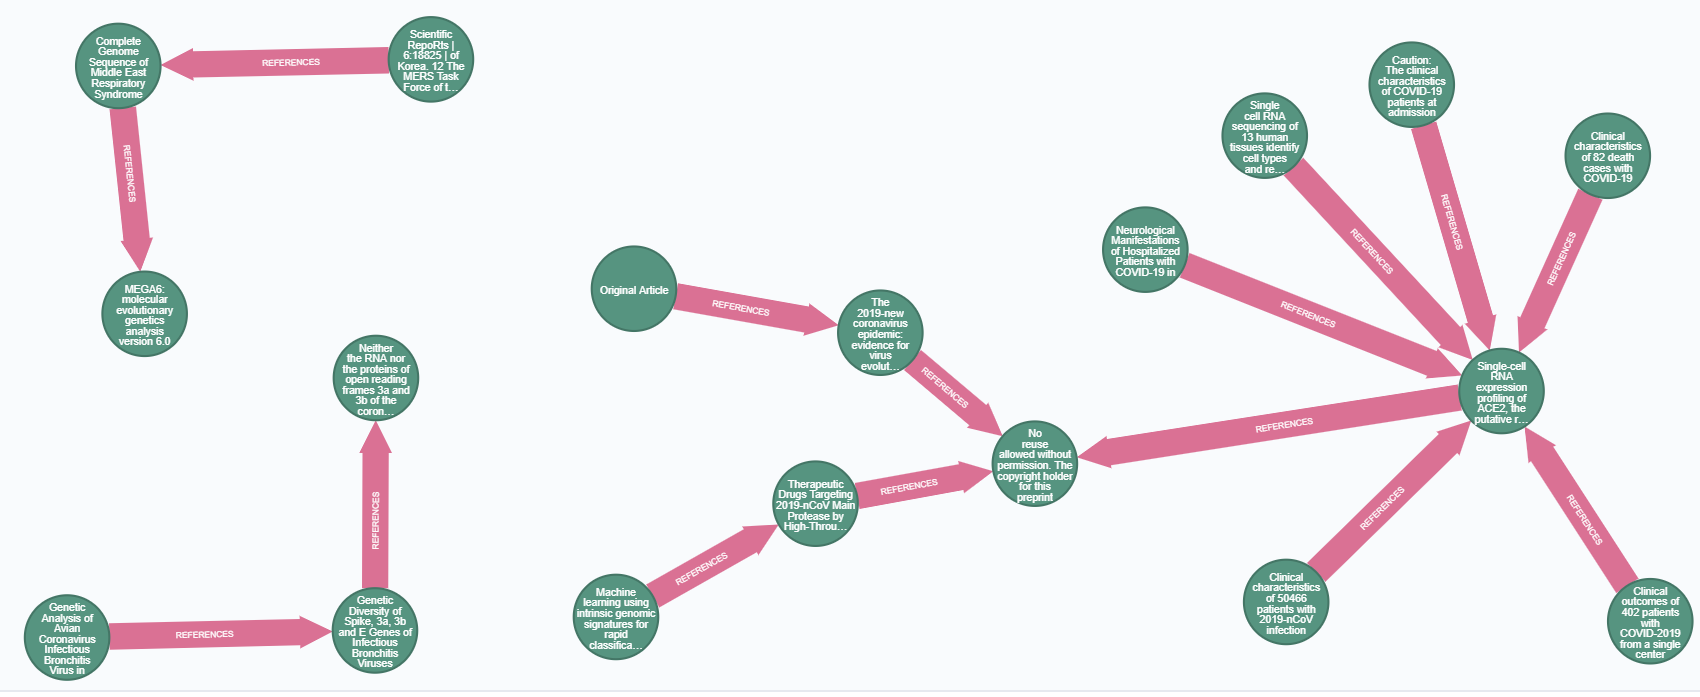

### Title (Bibliography) Graph

In [ ]:
bibs_graph = generate_graph(bibs_nodes, bibs_edges)

## Betweenness Centrality
> Use Case: "Betweenness centrality is a way of detecting the amount of influence a node has over the flow of information in a graph...."<sup>1</sup>

>Calculation:"The Betweenness Centrality algorithm calculates the shortest (weighted) path between every pair of nodes in a connected graph, using the breadth-first search algorithm. Each node receives a score, based on the number of these shortest paths that pass through the node. Nodes that most frequently lie on these shortest paths will have a higher betweenness centrality score. "<sup>1</sup>

* Let's find out which paper and which author has been the most influential to other papers and authors.

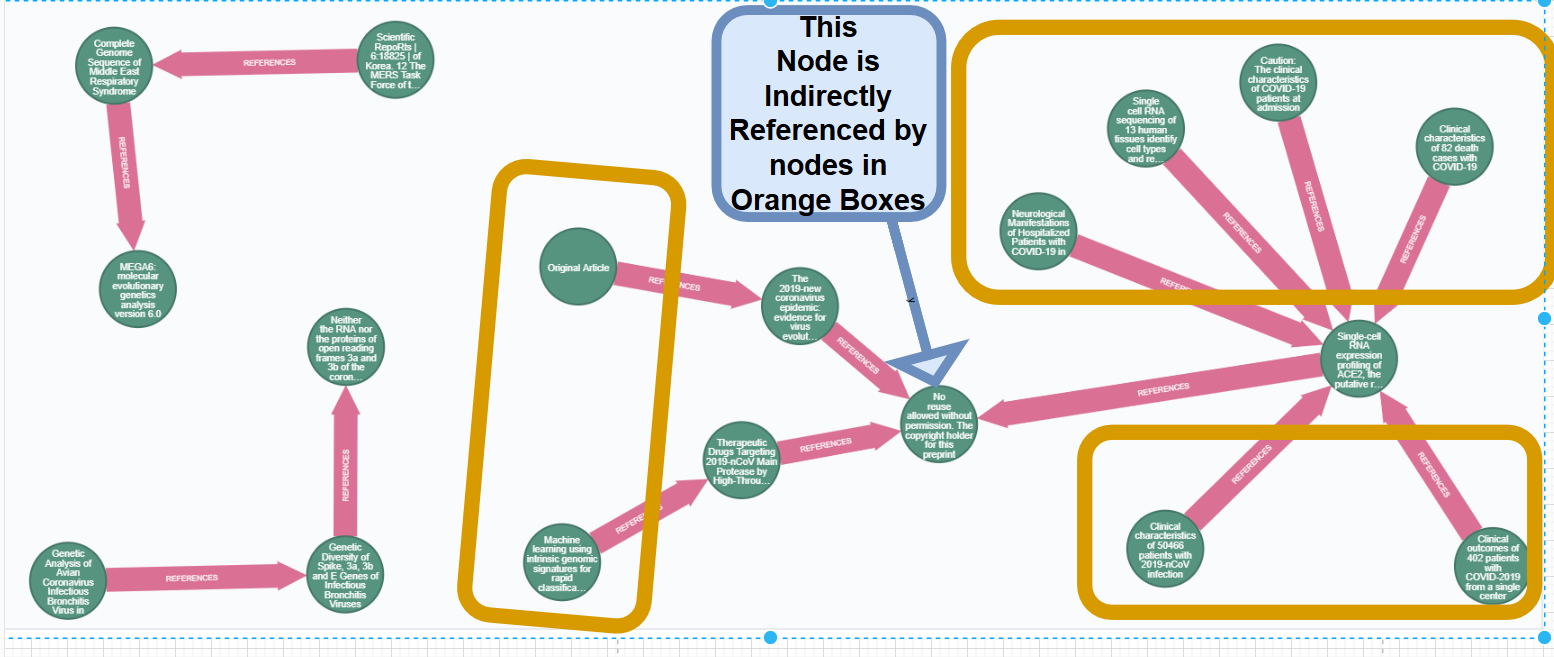

### Title (Bibliography) Betweenness Centrality

In [ ]:
bibs_df = betweenness_estimate_df(bibs_graph, 'Title')

In [ ]:
top_n_most_influential(bibs_df)

### Author Graph

In [ ]:
author_graph = generate_graph(author_nodes, author_edges)

## Author Betweenness Centrality

In [ ]:
author_df = betweenness_estimate_df(author_graph, 'Author')

In [ ]:
top_n_most_influential(author_df)

## By Source

In [ ]:
for use in use_types:
    print(use)
    bibs_nodes, bibs_edges, author_nodes, author_edges = \
        format_data_to_nodes_and_edges_for_graph([use], path_to_challenge)
    print(use + "- Title")
    bibs_graph = generate_graph(bibs_nodes, bibs_edges)
    bibs_df = betweenness_estimate_df(bibs_graph, 'Title')
    top_n_most_influential(bibs_df, source = use)  
    print(use + "- Author")
    author_graph = generate_graph(author_nodes, author_edges)
    author_df = betweenness_estimate_df(author_graph, 'Author')
    top_n_most_influential(author_df, source=use)

### Any constructive criticism on ways to optimize or perform a better analysis would be greatly appreciated.  
# Stay Healthy, everyone!

<sup>1</sup>https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/betweenness-centrality/